In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.FashionMNIST('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.FashionMNIST('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


60000

# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.40484294
K score 4 : 0.401194
K score 5 : 0.38752168
K score 6 : 0.40726084
K score 7 : 0.41844857
K score 8 : 0.41634244
K score 9 : 0.4213776
K score 10 : 0.42645898
K score 11 : 0.4256073
K score 12 : 0.42210254
K score 13 : 0.40927836
K score 14 : 0.39964756
K score 15 : 0.4004728
K score 16 : 0.392814
K score 17 : 0.3822038
K score 18 : 0.38366628
K score 19 : 0.38334218
K score 20 : 0.3639722
K score 21 : 0.36821952
K score 22 : 0.36233366
K score 23 : 0.36491117
K score 24 : 0.36813086
K score 25 : 0.37205648
K score 26 : 0.37132153
K score 27 : 0.37258834
K score 28 : 0.36769503
K score 29 : 0.3697737


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


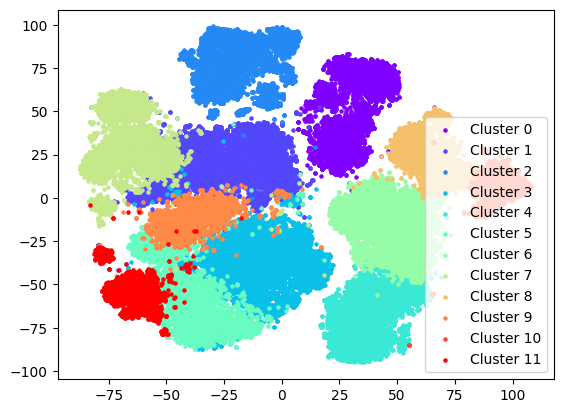

In [4]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 0.5 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=30) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [6]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [7]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [25]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.66134 time: 0.17827081680297852
[3] loss: 0.52093 time: 0.18133997917175293
[4] loss: 0.39339 time: 0.18786907196044922
[5] loss: 0.33331 time: 0.1821441650390625
[6] loss: 0.30602 time: 0.182053804397583
[7] loss: 0.29946 time: 0.19205164909362793
[8] loss: 0.28583 time: 0.18542003631591797
[9] loss: 0.27715 time: 0.1766505241394043
[10] loss: 0.26427 time: 0.1907978057861328
[11] loss: 0.25517 time: 0.19121527671813965
[12] loss: 0.25113 time: 0.18415331840515137
[13] loss: 0.24272 time: 0.18766117095947266
[14] loss: 0.24096 time: 0.1764509677886963
[15] loss: 0.23869 time: 0.1786956787109375
[16] loss: 0.23990 time: 0.1976923942565918
[17] loss: 0.22933 time: 0.19294071197509766
[18] loss: 0.22477 time: 0.181549072265625
[19] loss: 0.22357 time: 0.19525504112243652
[20] loss: 0.21821 time: 0.1853170394897461
[21] loss: 0.21412 time: 0.18495988845825195
[22] loss: 0.21245 time: 0.18701982498168945
[23] loss: 0.21630 time: 0.18527889251708984
[24] loss: 0.20995 time: 0.18

(1000, 56.35101450141519)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


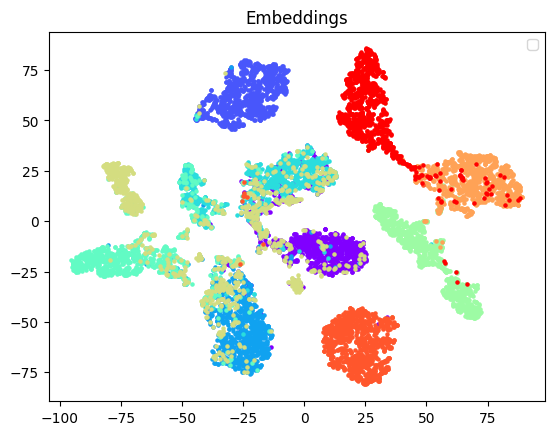

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


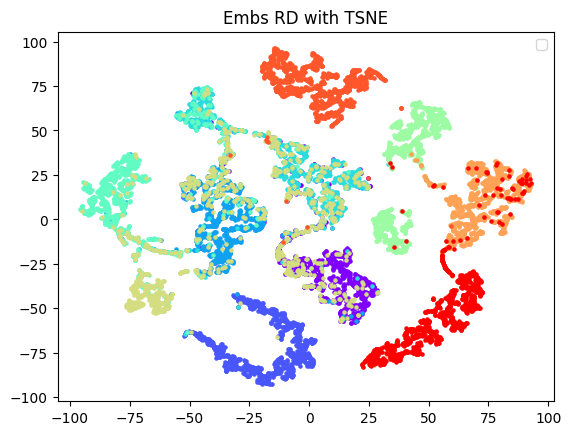

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


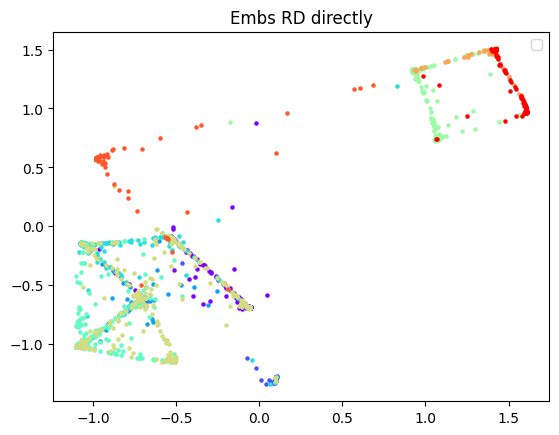

In [26]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [15]:
res = {}

In [27]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = resmap
resmap

Método proposto sem margem moderada


0.739760311720701

In [8]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses)).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 1.00758 time: 0.17297935485839844
[3] loss: 0.63881 time: 0.16017794609069824
[4] loss: 0.47194 time: 0.15035176277160645
[5] loss: 0.43230 time: 0.15075397491455078
[6] loss: 0.38365 time: 0.15576910972595215
[7] loss: 0.37810 time: 0.15715289115905762
[8] loss: 0.35129 time: 0.1458137035369873
[9] loss: 0.34304 time: 0.1497175693511963
[10] loss: 0.32746 time: 0.14340972900390625
[11] loss: 0.32158 time: 0.14363980293273926
[12] loss: 0.31409 time: 0.14945721626281738
[13] loss: 0.30029 time: 0.1558687686920166
[14] loss: 0.29655 time: 0.15893125534057617
[15] loss: 0.28801 time: 0.15905213356018066
[16] loss: 0.28393 time: 0.15560102462768555
[17] loss: 0.28524 time: 0.15838289260864258
[18] loss: 0.27436 time: 0.15796852111816406
[19] loss: 0.27647 time: 0.15145325660705566
[20] loss: 0.27609 time: 0.14902853965759277
[21] loss: 0.28342 time: 0.1444530487060547
[22] loss: 0.26665 time: 0.15346908569335938
[23] loss: 0.25759 time: 0.1530458927154541
[24] loss: 0.25638 time

(1000, 68.6800886801)

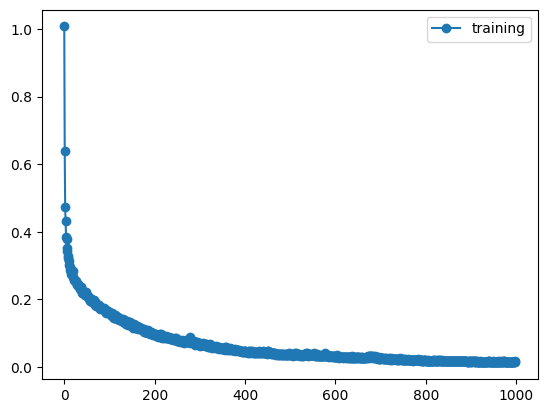

In [9]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


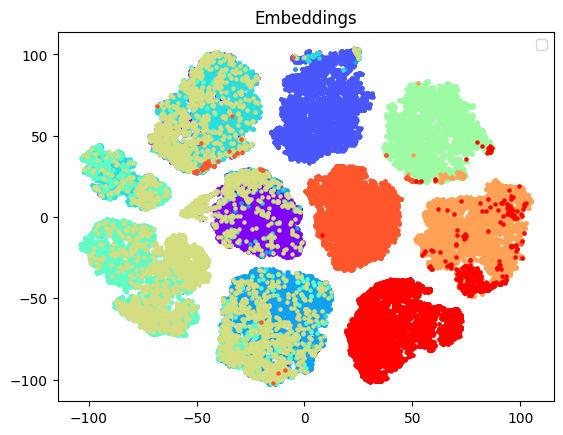

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


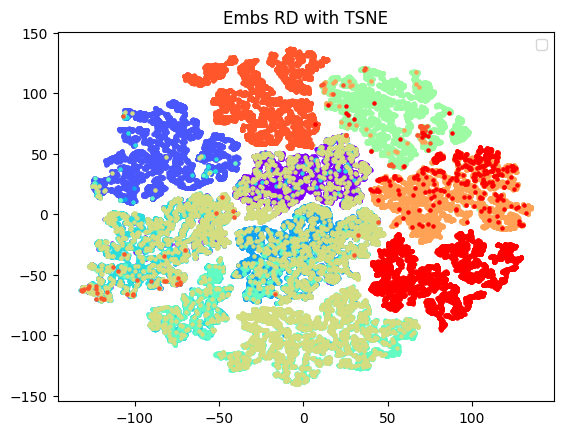

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


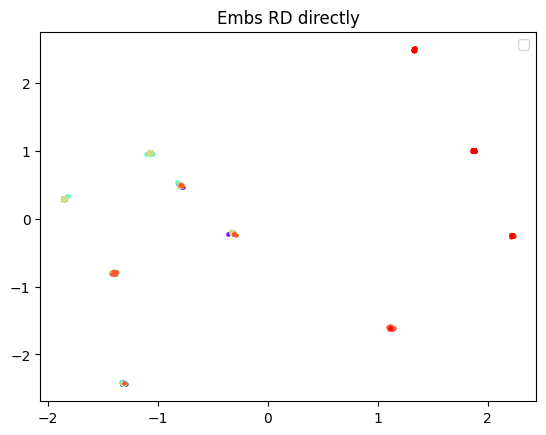

In [31]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


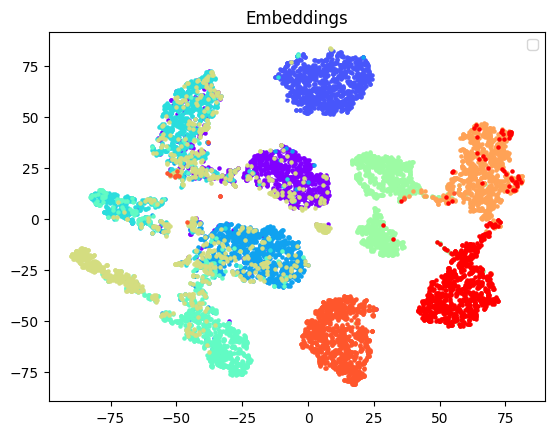

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


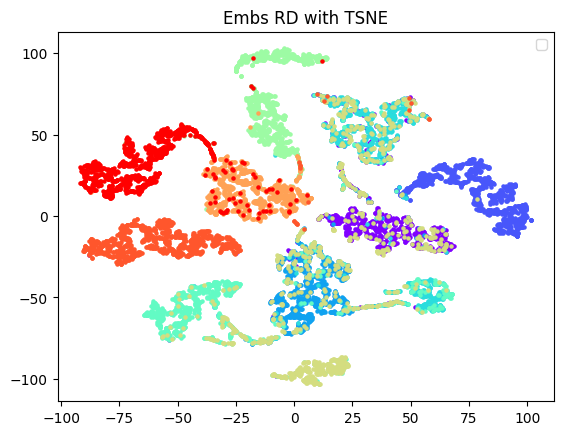

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


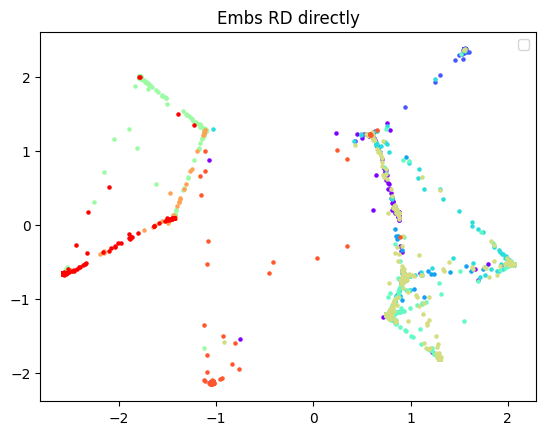

In [10]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to("cuda").unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [16]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = resmap
resmap

Método proposto


0.7428618020435693

In [17]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = resmap
resmap

Método proposto High Dim


0.7598953057386756

In [18]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = resmap
resmap

Sem projeção


0.5907189059286249

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = resmap
resmap

PCA


0.3726708003698397

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


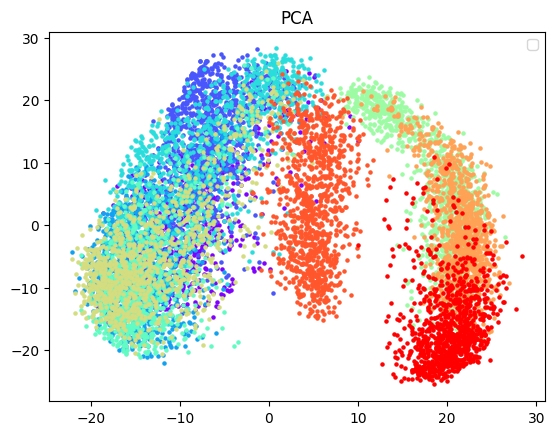

In [20]:
plotsmart(X_pca, lbs, "PCA", True)

In [21]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = resmap
resmap

T-SNE


0.7127510106401982

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


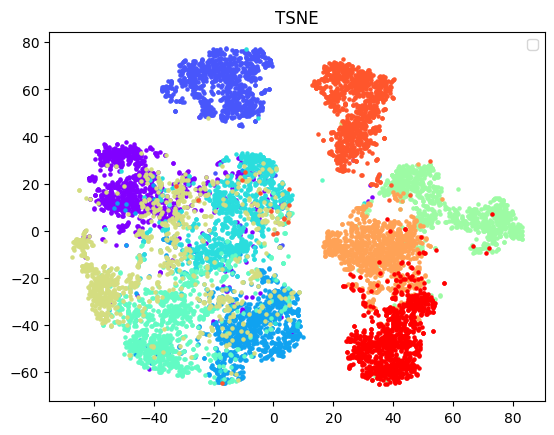

In [22]:
plotsmart(totsne(X), lbs, "TSNE", True)

In [23]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = resmap
resmap

UMAP


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.7430348589475292

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


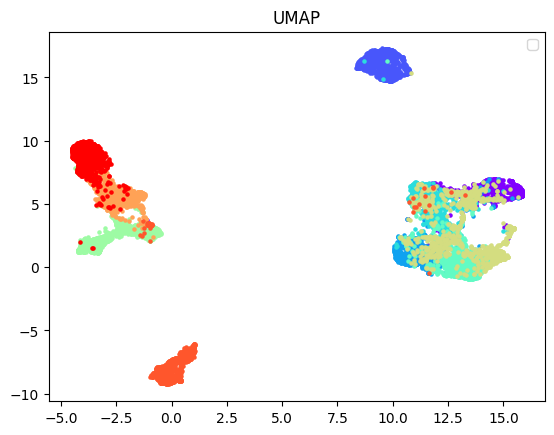

In [24]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [28]:
res

{'ours_with_mg': 0.7428618020435693,
 'ours_with_mg_highdim': 0.7598953057386756,
 'no_projection': 0.5907189059286249,
 'pca': 0.3726708003698397,
 'tsne': 0.7127510106401982,
 'umap': 0.7430348589475292,
 'ours_not_mg': 0.739760311720701}